In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import nltk
import pandas as pd
import keras
import numpy as np
from gensim.models import KeyedVectors
from collections import Counter
import multiprocessing
from nltk.corpus import stopwords
from string import punctuation
import multiprocessing
from gensim.models import Word2Vec

import collections
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Importing utility functions from Keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Input, InputLayer

import pickle



In [2]:
with open('tokenized_df.pickle', 'rb') as handle:
    data = pickle.load(handle)

data["label"] = data["label"].astype('int')
data["label"].value_counts()


 1    97764
 0    80800
-1    52568
Name: label, dtype: int64

<AxesSubplot:ylabel='Frequency'>

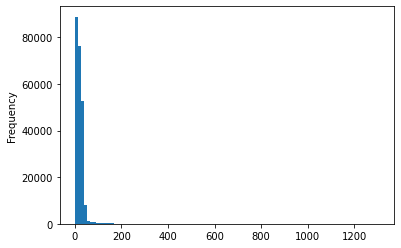

In [3]:
data["tokens"].apply(lambda x: len(x)).plot(kind='hist', bins=100)

In [4]:
from gensim.models import keyedvectors,KeyedVectors

embeddings = KeyedVectors.load_word2vec_format('embeddings_unks_25.txt', binary=False)


In [83]:
from time import time_ns
from keras.preprocessing.text import Tokenizer

def read_embeddings(embeddings: KeyedVectors,tokenizer: Tokenizer) -> tuple[dict[str,list], dict[int,list]]:
    '''Loads and parses embeddings trained in earlier.
    Parameters and return values are up to you.
    '''
    embeddings_size = len(embeddings[embeddings.index_to_key[0]])
    # str : array mapping
    word_embeddings = {w:embeddings[w] for w in tokenizer.word_index } # TODO: mmake compatible with pre-made embeddings
    # int : array mapping
    encoded_embeddings = {tokenizer.word_index[w]:word_embeddings[w] for w in word_embeddings}
    encoded_embeddings[0] = np.zeros(embeddings_size)
    return word_embeddings, encoded_embeddings

def get_enc_embed(embeddings: KeyedVectors,tokenizer: Tokenizer) -> tuple[dict[str,list], dict[int,list]]:
    '''Loads and parses embeddings trained in earlier.
    Parameters and return values are up to you.
    '''
    embeddings_size = len(embeddings[embeddings.index_to_key[0]])
    # int : array mapping
    encoded_embeddings = {tokenizer.word_index[w]:embeddings[w] for w in embeddings.index_to_key if w in tokenizer.word_index}
    encoded_embeddings[0] = np.zeros(embeddings_size)
    return encoded_embeddings


def get_X_and_y(data : pd.DataFrame, tokenizer: Tokenizer, enc_embed:dict):
    '''Returns X and y from the data.
    '''
    # convert text to sequences

    # pad sequences to length 50
    padded_seqs = pad_sequences(tokenizer.texts_to_sequences(data["tokens"]), maxlen=50, padding='post')
    # X =  np.array([[weight for token in seq for weight in enc_embed[token]] for seq in padded_seqs])
    y = to_categorical(data["label"].values+1)
    return padded_seqs,y

def get_bow_and_labels(data : pd.DataFrame, tokenizer: Tokenizer):
    '''Returns X and y from the data.
    '''
    # convert text to sequences
    # feature_vocab = [word for word, count in counter.most_common(100)]

    X = tokenizer.texts_to_matrix(data["tokens"], mode='count')
    y = to_categorical(data["label"].values+1)
    return X,y

def data_generator(padded_seqs, y, batch_size: int, enc_embed) -> tuple[list,list]:
    '''
    Returns data generator to be used by feed_forward
    https://wiki.python.org/moin/Generators
    https://realpython.com/introduction-to-python-generators/
    
    Yields batches of embeddings and labels to go with them.
    Use one hot vectors to encode the labels 
    (see the to_categorical function)
    
    '''
    while True:
        i = 0
        for i in range(0,len(y),batch_size):
            next_i = min(len(y), i+batch_size)
            # for each sequence in the batch, flatten all word embedding vectors into one vector
            X_batch = padded_seqs[i:next_i]
            embeddings =  np.array([[weight for token in seq for weight in enc_embed[token]] for seq in X_batch])

            # generate categorical data
            labels = y[i:next_i]
            yield embeddings, labels

def bow_generator(X, y, batch_size: int, enc_embed) -> tuple[list,list]:
    '''
    Returns data generator to be used by feed_forward
    https://wiki.python.org/moin/Generators
    https://realpython.com/introduction-to-python-generators/
    
    Yields batches of embeddings and labels to go with them.
    Use one hot vectors to encode the labels 
    (see the to_categorical function)
    
    '''
    while True:
        i = 0
        for i in range(0,len(y),batch_size):
            next_i = min(len(y), i+batch_size)
            # for each sequence in the batch, flatten all word embedding vectors into one vector
            X_batch = X[i:next_i]
            embeddings = np.array([[weight for token in bows for weight in enc_embed[token]] for bows in X_batch])
            # embeddings =  np.array([[weight * int(bows[idx]) for idx in range(len(bows)) for weight in enc_embed[idx]] for bows in X_batch])

            # generate categorical data
            labels = y[i:next_i]
            yield embeddings, labels

In [70]:
# given lines of text (arraylike) and embeddings (model.wv)
def train_model(X, y, tokenizer: Tokenizer, enc_embed:dict,epochs=100, x_val=None, y_val=None):
   

    # print("X:",X)
    # print("y:",y)

    # get word embeddings dictionaries for our corpus
    

    embeddings_size = len(enc_embed[1])
    batch_size = 32
    data_gen = bow_generator(X, y, batch_size=batch_size, enc_embed=enc_embed)
    data_gen_val = bow_generator(x_val, y_val, batch_size=batch_size, enc_embed=enc_embed)
    sample = next(data_gen)
    # print(sample.shape)

    # Define the model architecture using Keras Sequential API
    model = Sequential()
    model.add(layer_h0 := Dense(100, input_shape=(len(sample[0][0]),))) 
    model.add(layer_h1 := Dense(50, activation='relu'))
    model.add(layer_o := Dense(len(y[0]),activation="softmax")) 

    # setup model for learning
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    
    # train the model
    history = model.fit(data_gen, epochs=epochs, steps_per_epoch=len(X)//32, verbose=1, 
                        validation_steps=len(x_val)//32, validation_data=data_gen_val)

    # return the model, tokenizer, and embedding dict for sentence generation use later
    return model,tokenizer,history



## Train the models on our embeddings!

In [105]:
from collections import Counter
import os

tokenizer = Tokenizer(num_words=500, oov_token="UNK")
tokenizer.fit_on_texts(data["tokens"])
# word_counter = Counter([token for line in data["tokens"] for token in line])
# print(len(word_counter))

epochs = 3

small_data = data.sample(frac=0.25, random_state=69)

for embbeddings_size in [25,50,100,200]:
    if os.path.exists(f'ffnn{embbeddings_size}_{epochs}_epochs.pickle'):
        print("ffnn already trained for this embedding size")
        continue
    embeddings = KeyedVectors.load_word2vec_format(f'embeddings_unks_{embbeddings_size}.txt', binary=False)
    word_embed, enc_embed = read_embeddings(embeddings, tokenizer)
    X,y = get_bow_and_labels(small_data,tokenizer)
    X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y, test_size=0.5, random_state=69)
    X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
    net, tok, history = train_model(X_train, y_train,tokenizer, enc_embed, epochs=epochs, x_val=X_val, y_val=y_val)
    # save history to pickle file
    with open(f'ffnn{embbeddings_size}_{epochs}_epochs_history.pickle', 'wb') as handle:
        pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(f'ffnn{embbeddings_size}_{epochs}_epochs_model.pickle', 'wb') as handle:
        pickle.dump(net, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(net.evaluate(data_generator(X_test, y_test, batch_size=32, enc_embed=enc_embed), steps=len(X_test)//32))
    


Epoch 1/3
902/902 [==============================] - 79s 87ms/step - loss: 0.7646 - accuracy: 0.6750 - val_loss: 0.6461 - val_accuracy: 0.7340
Epoch 2/3
902/902 [==============================] - 83s 92ms/step - loss: 0.6626 - accuracy: 0.7263 - val_loss: 0.5900 - val_accuracy: 0.7589
Epoch 3/3
902/902 [==============================] - 82s 91ms/step - loss: 0.6089 - accuracy: 0.7501 - val_loss: 0.5479 - val_accuracy: 0.7793
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                          

In [104]:
# load in all models and evaluate them
with open('ffnn25_10_epochs_model.pickle', 'rb') as handle:
    net25_10 = pickle.load(handle)
with open('ffnn25_3_epochs_model.pickle', 'rb') as handle:
    net25_3 = pickle.load(handle)

# evaluate the models
embeddings = KeyedVectors.load_word2vec_format(f'embeddings_unks_{25}.txt', binary=False)
word_embed, enc_embed = read_embeddings(embeddings, tokenizer)
X,y = get_bow_and_labels(small_data,tokenizer)
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y, test_size=0.5, random_state=69)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
print(net25_3.evaluate(data_generator(X_test, y_test, batch_size=32, enc_embed=enc_embed), steps=len(X_test)//32))
print(net25_10.evaluate(data_generator(X_test, y_test, batch_size=32, enc_embed=enc_embed), steps=len(X_test)//32))

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-04-18 01:50:02         1852
metadata.json                                  2023-04-18 01:50:02           64
variables.h5                                   2023-04-18 01:50:02     15085336
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive loading:
File Name                                             Modified             Size
config.json                       

In [9]:
epochs = 3
for embbeddings_size in [25,50,100,200]:
    if not os.path.exists(f'ffnn{embbeddings_size}_{epochs}_model.pickle'):
        print("model hasnt been trained yet")
        continue
    embeddings = KeyedVectors.load_word2vec_format(f'embeddings_unks_{embbeddings_size}.txt', binary=False)
    word_embed, enc_embed = read_embeddings(embeddings, tokenizer)
    X,y = get_X_and_y(small_data,tokenizer, enc_embed)
    X_train, X_test, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69)
    print(embbeddings_size)
    # load net from pickle file 
    with open(f'ffnn{embbeddings_size}.pickle', 'rb') as handle:
        net : Sequential = pickle.load(handle)
    print(net.evaluate(data_generator(X_test, y_test, batch_size=32, enc_embed=enc_embed), steps=len(X_test)//32))

25
Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-04-15 20:56:46         1841
metadata.json                                  2023-04-15 20:56:46           64
variables.h5                                   2023-04-15 20:56:46     78119768
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
288/288 [==============================] - 2s 7ms/step
[[2.0398690e-01 7.9601312e-01]
 [1.2165525e-01 8.7834477e-01]
 [9.9999988e-01 8.94353

## Train and Test twitter embeddings of size 25

In [97]:
from collections import Counter
import os

twitter_embeddings : KeyedVectors = gensim.downloader.load('glove-twitter-25')

vocab = set(twitter_embeddings.index_to_key)
BOW_SIZE = 500


filtered_data = data.copy()
filtered_data["tokens"] = filtered_data["tokens"].apply(lambda x: [item for item in x if item in vocab])

tok = Tokenizer(num_words=BOW_SIZE, oov_token=None)
tok.fit_on_texts(filtered_data["tokens"])

enc_embed = get_enc_embed(twitter_embeddings, tok)

small_filtered_data = filtered_data.sample(frac=0.25, random_state=69)

epochs = 3

X,y = get_bow_and_labels(small_filtered_data,tok)

twitter_gen = bow_generator(X, y, batch_size=32, enc_embed=enc_embed)
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y, test_size=0.5, random_state=69)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
net, tok, history = train_model(X_train, y_train,tok, enc_embed, epochs=epochs, x_val=X_val, y_val=y_val)
# save history to pickle file
with open(f'ffnn_twitter_{epochs}_epochs_history.pickle', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'ffnn_twitter_{epochs}_epochs_model.pickle', 'wb') as handle:
    pickle.dump(net, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(net.evaluate(data_generator(X_test, y_test, batch_size=32, enc_embed=enc_embed), steps=len(X_test)//32))

Epoch 1/3
902/902 [==============================] - 89s 99ms/step - loss: 0.7898 - accuracy: 0.6624 - val_loss: 0.6360 - val_accuracy: 0.7412
Epoch 2/3
902/902 [==============================] - 93s 103ms/step - loss: 0.6654 - accuracy: 0.7265 - val_loss: 0.5751 - val_accuracy: 0.7679
Epoch 3/3
902/902 [==============================] - 98s 108ms/step - loss: 0.6031 - accuracy: 0.7523 - val_loss: 0.5220 - val_accuracy: 0.7903
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                        

## Testing twitter embeddings of size 200

In [98]:
from collections import Counter
import os

twitter_embeddings : KeyedVectors = gensim.downloader.load('glove-twitter-200')

vocab = set(twitter_embeddings.index_to_key)
BOW_SIZE = 500


filtered_data = data.copy()
filtered_data["tokens"] = filtered_data["tokens"].apply(lambda x: [item for item in x if item in vocab])

tok = Tokenizer(num_words=BOW_SIZE, oov_token=None)
tok.fit_on_texts(filtered_data["tokens"])

enc_embed = get_enc_embed(twitter_embeddings, tok)

small_filtered_data = filtered_data.sample(frac=0.25, random_state=69)

epochs = 3

X,y = get_bow_and_labels(small_filtered_data,tok)

twitter_gen = bow_generator(X, y, batch_size=32, enc_embed=enc_embed)
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y, test_size=0.5, random_state=69)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
net, tok, history = train_model(X_train, y_train,tok, enc_embed, epochs=epochs, x_val=X_val, y_val=y_val)
# save history to pickle file
with open(f'ffnn_twitter_{epochs}_epochs_history.pickle', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'ffnn_twitter_{epochs}_epochs_model.pickle', 'wb') as handle:
    pickle.dump(net, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(net.evaluate(data_generator(X_test, y_test, batch_size=32, enc_embed=enc_embed), steps=len(X_test)//32))

Epoch 1/3
902/902 [==============================] - 566s 628ms/step - loss: 0.8249 - accuracy: 0.6444 - val_loss: 0.6503 - val_accuracy: 0.7304
Epoch 2/3
902/902 [==============================] - 559s 620ms/step - loss: 0.6839 - accuracy: 0.7152 - val_loss: 0.5947 - val_accuracy: 0.7556
Epoch 3/3
902/902 [==============================] - 558s 619ms/step - loss: 0.6343 - accuracy: 0.7372 - val_loss: 0.5609 - val_accuracy: 0.7701
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                    

## Analysis of all models

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-04-18 08:13:02         1852
metadata.json                                  2023-04-18 08:13:02           64
variables.h5                                   2023-04-18 08:13:02     15085336
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive loading:
File Name                                             Modified             Size
config.json                       

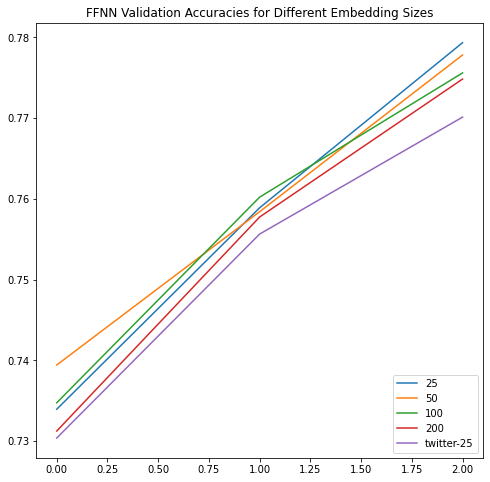

In [121]:
# read in all 3 epoch histories
with open('ffnn25_3_epochs_history.pickle', 'rb') as handle:
    history25_3 = pickle.load(handle)
with open('ffnn50_3_epochs_history.pickle', 'rb') as handle:
    history50_3 = pickle.load(handle)
with open('ffnn100_3_epochs_history.pickle', 'rb') as handle:
    history100_3 = pickle.load(handle)
with open('ffnn200_3_epochs_history.pickle', 'rb') as handle:
    history200_3 = pickle.load(handle)
with open('ffnn_twitter_3_epochs_history.pickle', 'rb') as handle:
    history_twitter_3 = pickle.load(handle)
with open('ffnn_twitter_3_epochs_history.pickle', 'rb') as handle:
    history_twitter_3 = pickle.load(handle)
# plot the validation accurracy for each epoch of each model
plt.plot(history25_3.history['val_accuracy'])
plt.plot(history50_3.history['val_accuracy'])
plt.plot(history100_3.history['val_accuracy'])
plt.plot(history200_3.history['val_accuracy'])
plt.plot(history_twitter_3.history['val_accuracy'])
plt.title('FFNN Validation Accuracies for Different Embedding Sizes')
# add legend to plot
plt.legend(['25', '50', '100', '200', 'twitter-25'], loc='lower right')
# set size  of figure
figure = plt.gcf()
figure.set_size_inches(8, 8)
# plt.rcParams["figure.figsize"] = (10,10)
plt.show()
